In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [362]:
# Loading data
mort = pd.read_csv('../data/apache_patient_result_data.csv')
finGCS = pd.read_csv('../data/loaded/final_gcs.csv')
finGCS = finGCS.loc[:, ['patientunitstayid', 'Value']]
mort = mort.drop_duplicates('patientunitstayid')
mort['death'] = mort['actualhospitalmortality'] != 'ALIVE'
mort['los'] = mort['actualhospitallos'].astype(float)
mort = mort.loc[:, ['patientunitstayid', 'death', 'los']]
mort = mort.merge(finGCS, on = 'patientunitstayid', how = 'left')
mort = mort.dropna()
mort['GCS'] = mort['Value'] != 6
display(mort)

losAlive = mort[mort['death'] == False].loc[:, ['los']].values
losDeath = mort[mort['death'] == True].loc[:, ['los']].values
# plt.figure(figsize = (8, 8))
# plt.boxplot([losAlive, losDeath], labels = ["Alive", "Dead"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs mortality", size = 16)
# plt.ylim((0, 25))
#plt.savefig("LOSvsMort.png", bbox_inches = 'tight')

mort = mort[mort['death']]
display(mort)


los1 = mort[mort['Value'] == 1].loc[:, ['los']].values
los2 = mort[mort['Value'] == 2].loc[:, ['los']].values
los3 = mort[mort['Value'] == 3].loc[:, ['los']].values
los4 = mort[mort['Value'] == 4].loc[:, ['los']].values
los5 = mort[mort['Value'] == 5].loc[:, ['los']].values
los6 = mort[mort['Value'] == 6].loc[:, ['los']].values

# plt.figure(figsize = (8, 8))
# plt.boxplot([los1, los2, los3, los4, los5, los6], labels = ["1", "2", "3", "4", "5", "6"])
# plt.xticks(size = 14)
# plt.yticks(size = 14)
# plt.ylabel("Length of ICU stay", size = 16)
# plt.title("Length of ICU Stay vs final GCS", size = 16)
# plt.ylim((0, 35))
#plt.savefig("LOSvsGCS.png", bbox_inches = 'tight')

,patientunitstayid,death,los,Value,GCS
1,1015921,False,3.4118,6.0,False
2,1823818,False,4.7326,6.0,False
4,2228330,False,45.5549,2.0,True
5,3073401,False,9.9813,6.0,False
6,3199652,False,11.8257,6.0,False
...,...,...,...,...,...
4498,1451537,False,5.1590,6.0,False
4501,2712577,False,3.2410,6.0,False
4502,1791019,False,0.8715,6.0,False
4503,2263791,False,10.7319,6.0,False


,patientunitstayid,death,los,Value,GCS
32,1711026,True,0.6549,1.0,True
43,300365,True,0.5646,1.0,True
44,2494195,True,0.7368,1.0,True
47,3072104,True,1.8715,3.0,True
53,3227462,True,7.8694,6.0,False
...,...,...,...,...,...
4433,1112856,True,7.7160,5.0,True
4434,2398559,True,0.8750,1.0,True
4447,1722740,True,6.2986,6.0,False
4457,3072527,True,1.8833,2.0,True


In [379]:
# Gathering the rest of data
ap = pd.read_csv('../data/loaded/processed/aperiodic_processed.csv')
ap = ap.iloc[:, [0, 2, 3, 4]]
ap = ap.set_index('patientunitstayid').add_prefix("AP_")

dem = pd.read_csv('../data/loaded/processed/dem_processed.csv')
dem = dem.set_index('patientunitstayid').add_prefix("DEM_")

inf = pd.read_csv('../data/loaded/processed/infusion_processed.csv')
inf = inf.set_index('patientunitstayid').add_prefix("INF_")

lab = pd.read_csv('../data/loaded/processed/lab_processed.csv')
lab = lab.set_index('patientunitstayid').add_prefix("LAB_")

med = pd.read_csv('../data/loaded/processed/medication_processed.csv')
med = med.set_index('patientunitstayid').add_prefix("MED_")

nc = pd.read_csv('../data/loaded/processed/nc_processed.csv')
nc['verbal'][nc['verbal'] > 6] = 6
nc['eyes'][nc['eyes'] > 6] = 6
nc = nc.iloc[:, [0, 2, 3, 4]]
nc = nc.fillna(nc.mean())
nc = nc.set_index('patientunitstayid').add_prefix("NC_")

resp = pd.read_csv('../data/loaded/processed/respiratory_processed.csv')
pd.set_option('display.max_columns', None)
resp.iloc[:, 1:] = resp.iloc[:, 1:] > 0
resp['entries'] = resp.iloc[:, 1:].sum(axis = 1) > 0
resp = resp.iloc[:, [0, 27]]
resp = resp.set_index('patientunitstayid').add_prefix("resp_")

X_ts = pd.read_csv('../data/loaded/processed/ts_processed.csv')
X_hr = X_ts[['patientunitstayid', 'offset_bin', 'hr']].pivot(index='patientunitstayid',
            columns='offset_bin', values='hr').reset_index()
X_resp = X_ts[['patientunitstayid', 'offset_bin', 'resp']].pivot(index='patientunitstayid',
            columns='offset_bin', values='resp').reset_index()
X_sao2 = X_ts[['patientunitstayid', 'offset_bin', 'sao2']].pivot(index='patientunitstayid',
            columns='offset_bin', values='sao2').reset_index()
X_gcs = X_ts[['patientunitstayid', 'offset_bin', 'gcs']].pivot(index='patientunitstayid',
            columns='offset_bin', values='gcs').reset_index()
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] > 6] = 6
X_gcs.iloc[:, 1:][X_gcs.iloc[:, 1:] < 1] = 1

pca = PCA(n_components = 5)
hrp = pca.fit_transform(X_hr.iloc[:, 1:])
respp = pca.fit_transform(X_resp.iloc[:, 1:])

sao2p = pca.fit_transform(X_sao2.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("sao2 PCA 0")
# plt.stem(pca.components_[0, :])

gcsp = pca.fit_transform(X_gcs.iloc[:, 1:])
# plt.figure(figsize = (8, 8))
# plt.title("GCS PCA 0")
# plt.stem(pca.components_[0, :])


hr = pd.DataFrame(hrp)
hr.columns = ['hr0', 'hr1', 'hr2', 'hr3', 'hr4']
hr['patientunitstayid'] = X_hr['patientunitstayid']

resp = pd.DataFrame(respp)
resp.columns = ['resp0', 'resp1', 'resp2', 'resp3', 'resp4']
resp['patientunitstayid'] = X_resp['patientunitstayid']

sao2 = pd.DataFrame(sao2p)
sao2.columns = ['sao20', 'sao21', 'sao22', 'sao23', 'sao24']
sao2['patientunitstayid'] = X_sao2['patientunitstayid']

gcs = pd.DataFrame(gcsp)
gcs.columns = ['gcs0', 'gcs1', 'gcs2', 'gcs3', 'gcs4']
gcs['patientunitstayid'] = X_gcs['patientunitstayid']

X = gcs.set_index('patientunitstayid').merge(hr.set_index('patientunitstayid'), how = 'left', left_index = True, right_index = True).merge(resp.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True).merge(sao2.set_index('patientunitstayid'), how = 'left',left_index = True, right_index = True)
Xn = X.merge(nc, how = 'left',left_index = True, right_index = True).merge(med,  how = 'left',left_index = True, right_index = True).merge(lab, how = 'left',left_index = True, right_index = True).merge(inf,  how = 'left',left_index = True, right_index = True).merge(dem,  how = 'left',left_index = True, right_index = True).merge(ap,  how = 'left',left_index = True, right_index = True)

# Mort Features
# Xn = Xn[['DEM_age', 'gcs0', 'INF_norepinephrine','INF_morphine', 'LAB_BUN', 'LAB_glucose', 'sao20', 'INF_phenylephrine', 'MED_4846.0', 'LAB_paCO2']]

# LOS Features
# Xn = Xn[['gcs0', 'MED_549.0', 'MED_2102.0', 'MED_1326.0', 'MED_25386.0', 'LAB_HCO3', 'LAB_Hct', 'LAB_O2 Sat (%)', 'LAB_Hgb', 'LAB_-lymphs']]

Xn = Xn.reset_index()

#out = GCS, los, death
out = "los"
Y = Xn.merge(mort)[out].values
Xns = Xn.merge(mort).iloc[:, :-4]
Xns = Xns.fillna(Xns.mean())
display(Y)
display(Xns)

X = Xns.drop('patientunitstayid', axis = 1).values
Xn = Xns.drop('patientunitstayid', axis = 1)

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([ 6.9319, 12.9792,  1.0847,  2.4007,  0.4479,  2.0063,  1.5514,
        1.2396, 41.3181,  0.5646,  1.9194,  0.8382,  2.5951,  1.4882,
        2.3097, 25.4854, 12.3715, 32.4944,  9.3167, 10.209 ,  7.0229,
        3.4021, 16.3215, 24.884 , 24.884 , 24.884 ,  1.3188,  0.9785,
        1.7361,  4.2875,  3.8806,  1.7014,  8.2764,  7.859 , 13.5188,
        3.2285, 11.2292, 11.0597, 13.2951,  3.3576,  0.9042,  7.716 ,
        7.716 ,  0.9201,  2.7757,  7.3701,  8.2931,  3.7771,  1.8924,
       12.9896,  0.7792,  5.9764,  1.9368,  4.5347,  2.716 ,  5.3972,
        2.4222,  1.6729, 13.7688, 12.7826,  8.1097,  3.559 ,  7.2438,
        8.0854,  2.3868,  4.5917, 27.5493,  5.3472,  4.9799, 11.4986,
        2.1444, 23.5292, 23.5292,  0.6549,  6.2986,  6.2986,  1.7236,
        2.4194,  1.809 ,  1.0319,  2.5778,  2.5778, 16.0069, 14.4354,
        1.4896, 13.041 ,  1.3396,  3.1576,  0.5042,  4.1674, 14.5785,
       14.059 ,  4.    , 20.4181,  4.2285,  1.916 , 21.9354, 21.9354,
        1.5153,  1.8

,patientunitstayid,gcs0,MED_549.0,MED_2102.0,MED_1326.0,MED_25386.0,LAB_HCO3,LAB_Hct,LAB_O2 Sat (%),LAB_Hgb,LAB_-lymphs
0,172448,21.395486,1.0,0.0,0.0,0.0,30.000000,31.900000,27.250,11.150000,8.000
1,268706,1.801272,0.0,0.0,0.0,0.0,24.000000,35.650000,98.000,12.600000,24.000
2,272480,20.786597,0.0,0.0,0.0,0.0,17.333333,27.300000,97.400,8.433333,21.000
3,282865,-3.097281,0.0,0.0,0.0,0.0,14.570000,37.800000,14.570,12.400000,5.800
4,284630,21.395486,0.0,0.0,0.0,0.0,21.050000,29.500000,97.500,9.900000,21.575
...,...,...,...,...,...,...,...,...,...,...,...
211,3239108,0.797792,1.0,1.0,0.0,0.0,28.000000,38.200000,100.000,12.300000,15.500
212,3241910,4.664164,1.0,0.0,1.0,1.0,21.160000,38.333333,97.100,13.000000,22.000
213,3340433,21.395486,1.0,0.0,0.0,0.0,21.600000,43.000000,77.500,14.400000,18.000
214,3343722,21.395486,1.0,0.0,0.0,0.0,18.340000,43.000000,95.800,14.300000,16.320


In [364]:
death = list(mort['death'])
los = list(mort['los'])
y = [(death[i], los[i]) for i in range(len(death))]
print(y)
print(pd.Series(y))

[(True, 0.6549), (True, 0.5646), (True, 0.7368), (True, 1.8715), (True, 7.8694), (True, 23.5292), (True, 1.3486), (True, 3.2417), (True, 39.5132), (True, 2.2986), (True, 1.3396), (True, 41.3181), (True, 7.3819), (True, 1.8479), (True, 6.6097), (True, 0.8861), (True, 2.6104), (True, 1.3903), (True, 40.616), (True, 1.1799), (True, 4.2569), (True, 13.4667), (True, 3.7313), (True, 3.1576), (True, 0.9354), (True, 4.2875), (True, 1.2354), (True, 21.9354), (True, 7.4285), (True, 11.6167), (True, 2.7125), (True, 7.0089999999999995), (True, 3.2438), (True, 2.6382), (True, 7.2438), (True, 1.6451), (True, 20.4139), (True, 0.9785), (True, 6.9319), (True, 2.9535), (True, 0.9764), (True, 10.6167), (True, 1.5153), (True, 2.4222), (True, 1.3444), (True, 0.9201), (True, 2.4194), (True, 1.6729), (True, 1.6167), (True, 0.8431), (True, 1.3792), (True, 0.8), (True, 3.9403), (True, 0.6521), (True, 11.2243), (True, 5.275), (True, 1.7167), (True, 5.1403), (True, 7.716), (True, 1.0465), (True, 2.5382), (True, 

In [369]:
# Finding number who were alive by end of hospital stay
num_alive = sum([i == False for i in death])
num_dead = sum(death)

print("Num alive: %d" % num_alive)
print("Num dead: %d" % num_dead)

Num alive: 0
Num dead: 216


Text(0.5, 1.0, 'Survival Curve for Patient Sample')

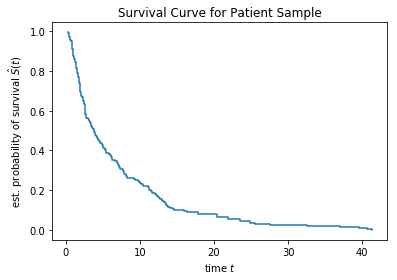

In [370]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(death, los)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival Curve for Patient Sample')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,268706,True,12.9792,1.0,True
2,272480,True,1.0847,1.0,True
3,282865,True,2.4007,6.0,False
4,284630,True,0.4479,1.0,True
...,...,...,...,...,...
211,3239108,True,17.5201,6.0,False
212,3241910,True,6.2493,5.0,True
213,3340433,True,0.6368,1.0,True
214,3343722,True,3.8396,1.0,True


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


Text(0.5, 1.0, 'Survival Curves by Age')

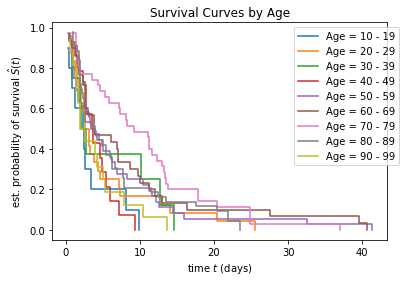

In [371]:
ages = list(range(0, 110, 10))
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
print(ages)

for i in range(len(ages)-1):
    mask_treat_lower = list(Xns['DEM_age'] >= ages[i])
    mask_treat_upper = list(Xns['DEM_age'] < ages[i+1])
    mask_treat = [mask_treat_lower[i] and mask_treat_upper[i] for i in range(len(mask_treat_lower))]
    if sum(mask_treat) == 0:
        continue
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Age = %s - %s" % (ages[i], ages[i+1]-1))

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
# plt.legend(loc ="best")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title('Survival Curves by Age')

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,268706,True,12.9792,1.0,True
2,272480,True,1.0847,1.0,True
3,282865,True,2.4007,6.0,False
4,284630,True,0.4479,1.0,True
...,...,...,...,...,...
211,3239108,True,17.5201,6.0,False
212,3241910,True,6.2493,5.0,True
213,3340433,True,0.6368,1.0,True
214,3343722,True,3.8396,1.0,True


[1, -1]


Text(0.5, 1.0, 'Survival Curves by Gender')

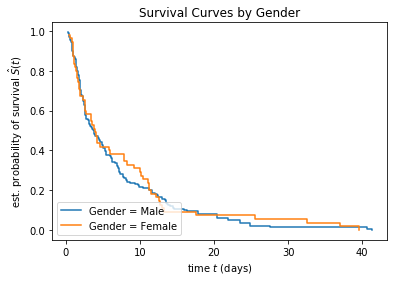

In [372]:
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
genders = list(Xns['DEM_gender'].drop_duplicates())
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])

print(genders)
for g in genders:
    mask_treat = list(Xns['DEM_gender'] == g)
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        np.array(death)[mask_treat],
        np.array(los)[mask_treat])
    if g == 1:
        label = "Male"
    elif g == -1:
        label = "Female"
    elif g == 0:
#         label = "Other"
        continue

    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Gender = %s" % label)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")
plt.legend(loc="lower left")
plt.title('Survival Curves by Gender')

In [373]:
# Getting y values
mort_filtered = pd.merge(Xns['patientunitstayid'], mort, how='inner')
display(mort_filtered)
death = list(mort_filtered['death'])
los = list(mort_filtered['los'])
y = np.array([(death[i], los[i]) for i in range(len(death))], dtype=[('Status', 'bool'), ('Survival_in_days', 'float')])

,patientunitstayid,death,los,Value,GCS
0,172448,True,6.9319,1.0,True
1,268706,True,12.9792,1.0,True
2,272480,True,1.0847,1.0,True
3,282865,True,2.4007,6.0,False
4,284630,True,0.4479,1.0,True
...,...,...,...,...,...
211,3239108,True,17.5201,6.0,False
212,3241910,True,6.2493,5.0,True
213,3340433,True,0.6368,1.0,True
214,3343722,True,3.8396,1.0,True


In [380]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

yclass = np.array(death)
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=6)
trainpredsss = []
testpredsss = []
trainlabsss = []
testlabsss = []
i = 0

best_y_pred = []
best_concordance = 0

metrics = []
scaler = StandardScaler()
coefs = np.zeros((20, X.shape[1]))
for train_index, test_index in sss.split(X, yclass):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = CoxnetSurvivalAnalysis()
    model2 = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    model.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    survival = model2.predict_survival_function(X_test)
    y_pred = model.predict(X_test)
    metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
    metrics.append(metric)
    if (metric[0] > best_concordance):
        best_concordance = metric[0]
        best_y_pred = y_pred
        
y_pred = best_y_pred

C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_feat

C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_features, 0.01 will be used instead.
  FutureWarning)
C:\Users\owner\Anaconda3\lib\site-packages\sksurv\linear_model\coxnet.py:211: FutureWarning: The default value of alpha_min_ratio will depend on the sample size relative to the number of features in 0.13. If n_samples > n_features, the current default value 0.0001 will be used. If n_samples < n_feat

In [295]:
print(metrics)
print()
concordances = [m[0] for m in metrics]
print(np.mean(concordances))

[(0.8635770234986945, 17199, 2717, 0, 3), (0.8691926491843899, 16838, 2534, 0, 1), (0.8668338003244359, 17634, 2709, 0, 1), (0.8165378592716068, 16165, 3632, 0, 3), (0.8865099492781896, 18177, 2327, 0, 0), (0.8536740900618072, 17403, 2983, 0, 1), (0.8213134135855547, 15283, 3325, 0, 4), (0.807062382641352, 15473, 3699, 0, 1), (0.8552314690928552, 15980, 2705, 0, 0), (0.8833873427373237, 18537, 2447, 0, 2), (0.8390123456790124, 16990, 3260, 0, 2), (0.8427376099549453, 15712, 2932, 0, 3), (0.84171533636167, 15565, 2927, 0, 2), (0.8470884360327218, 17500, 3159, 0, 0), (0.8366902558519325, 15370, 3000, 0, 2), (0.8405790154819537, 17537, 3326, 0, 1), (0.8896738604471112, 18386, 2280, 0, 0), (0.8446018042487147, 17414, 3204, 0, 0), (0.8387132011579005, 15356, 2953, 0, 0), (0.8981654810932235, 16793, 1904, 0, 0)]

0.8521148662992697


2.634
False


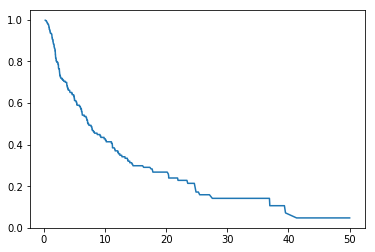

3.3389
False


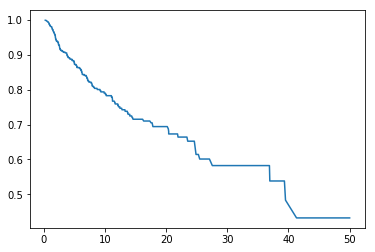

1.7028
True


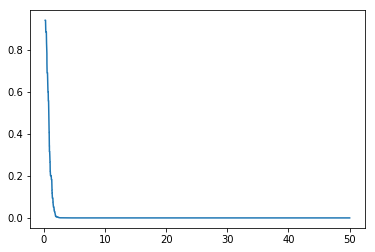

predict death
[1.3847 1.3854 1.4035 1.4069 1.4083 1.4313 1.4326 1.4354 1.4861]

4.9375
False


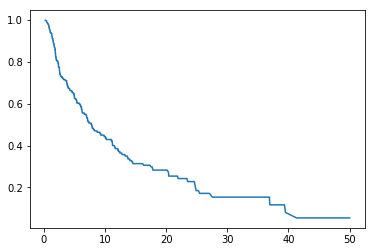

13.6257
False


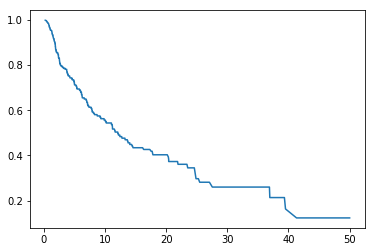

3.2799
False


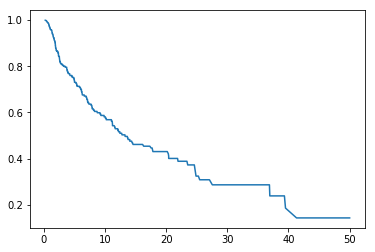

1.5972
False


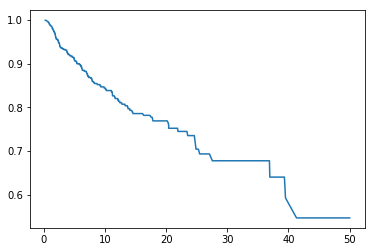

5.3111
False


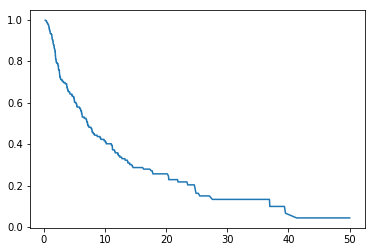

10.7111
False


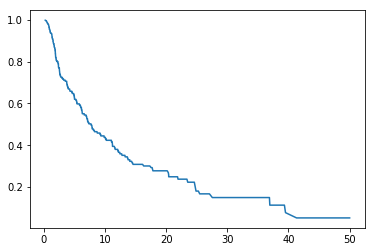

1.7236
True


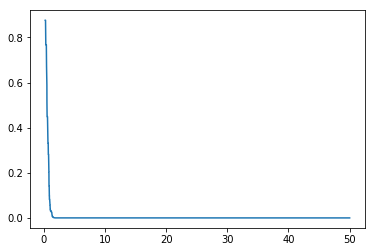

predict death
[0.9042 0.916 ]

9.2222
False


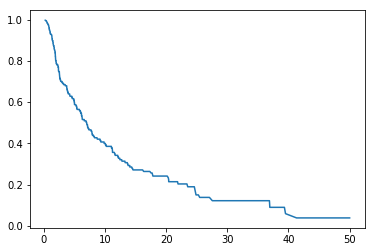

4.7569
False


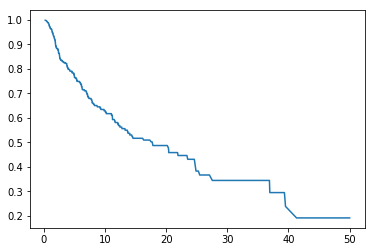

7.6917
False


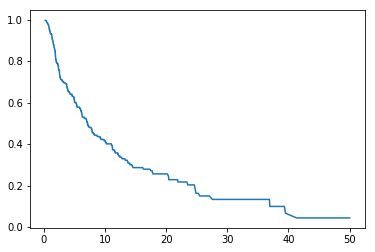

35.7674
False


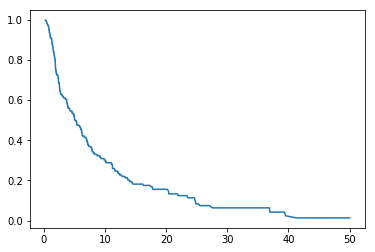

1.8764
True


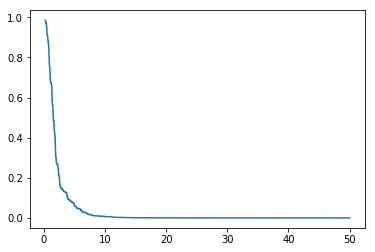

3.0847
False


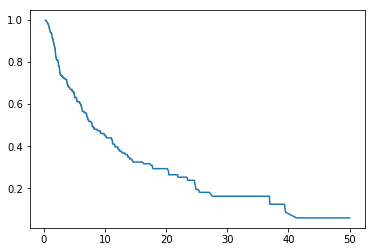

4.9181
False


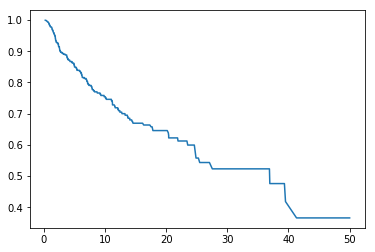

1.9104
False


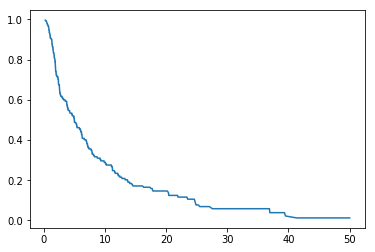

4.2646
False


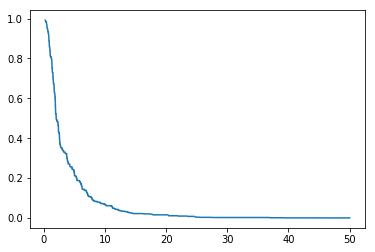

7.6229
False


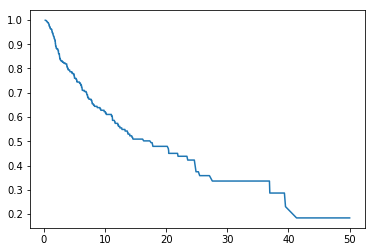

2.7347
False


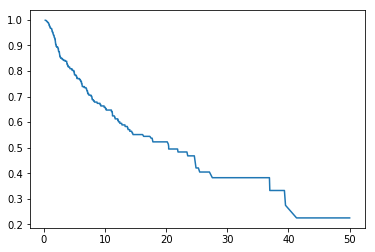

13.2403
False


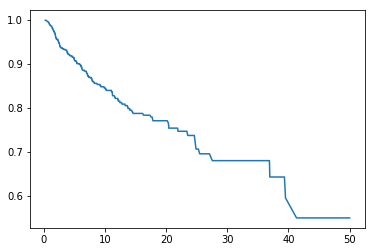

5.1160000000000005
False


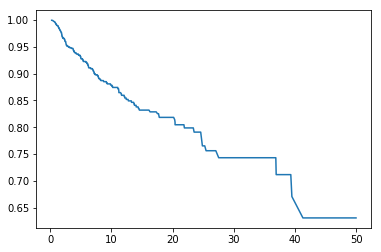

8.8278
False


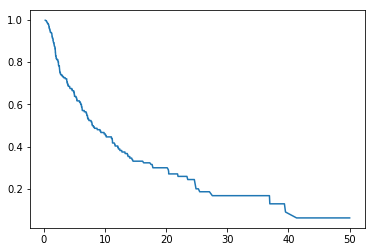

10.216000000000001
False


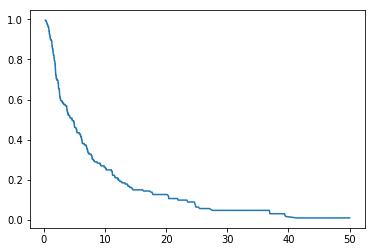

13.5181
False


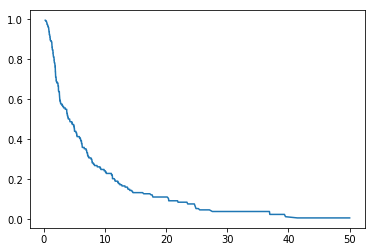

21.1069
False


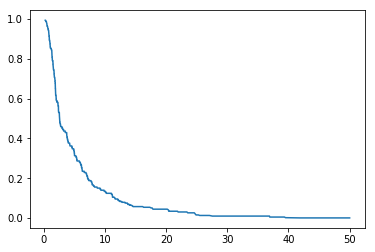

3.384
False


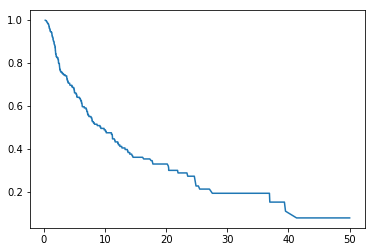

42.7361
False


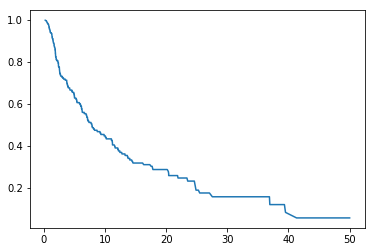

3.6208
False


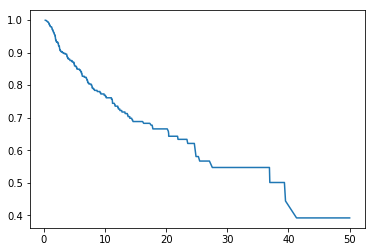

28.6333
False


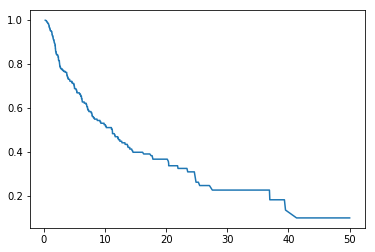

13.5188
True


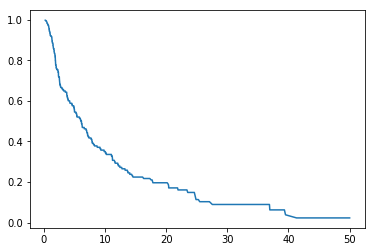

3.6222
False


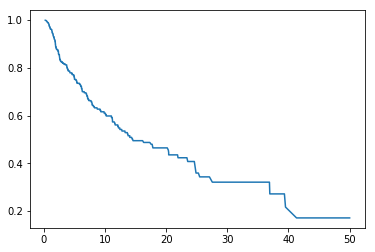

1.9507
False


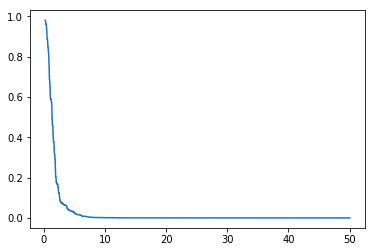

4.9188
False


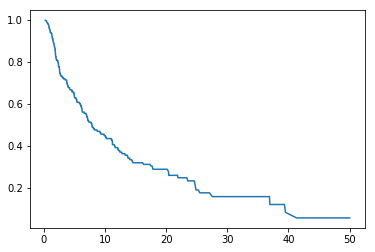

12.4042
False


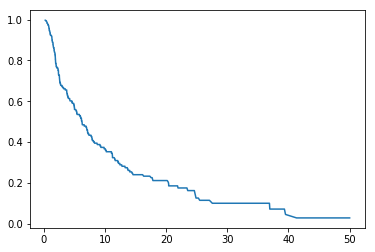

14.7354
False


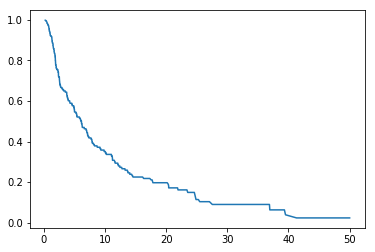

14.7472
False


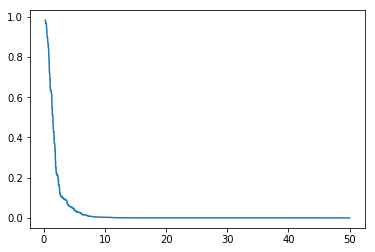

0.9785
True


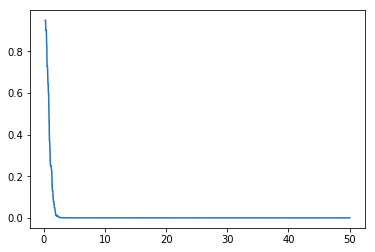

predict death
[1.5153 1.5229 1.5264 1.5313]

8.0854
False


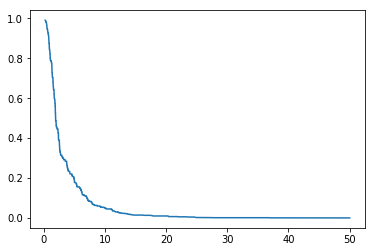

16.441
False


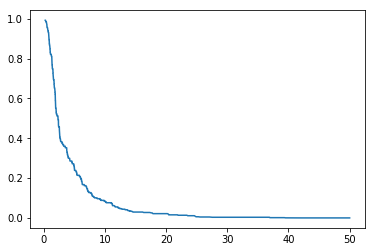

3.6458
False


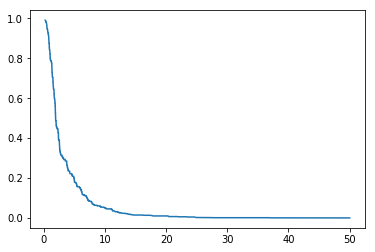

2.1618
False


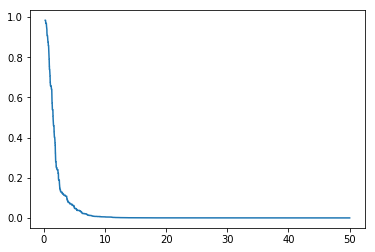

21.4681
False


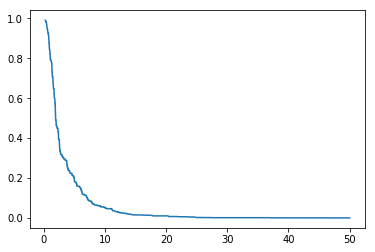

2.6104
True


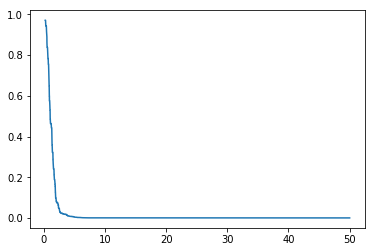

7.8326
False


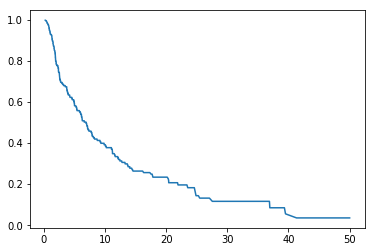

5.834
False


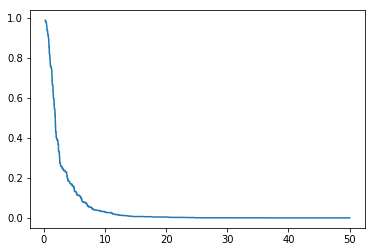

3.0854
False


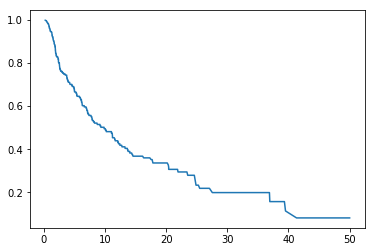

1.6549
False


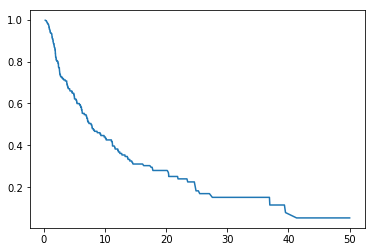

8.5458
False


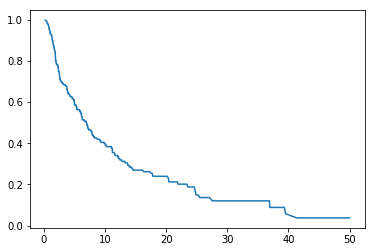

9.8951
False


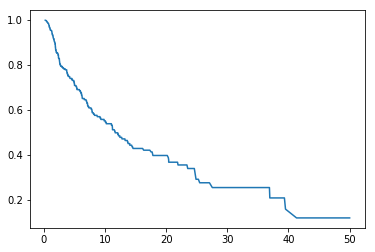

21.5819
False


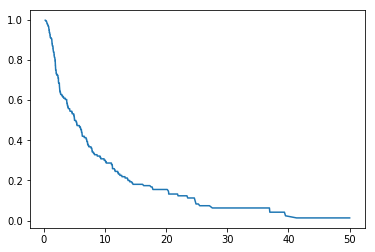

2.334
False


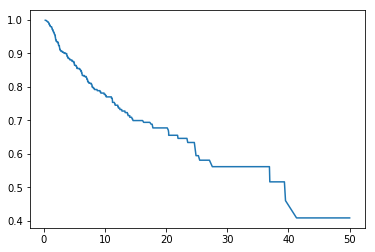

8.8833
False


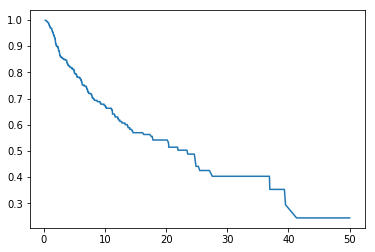

7.8736
False


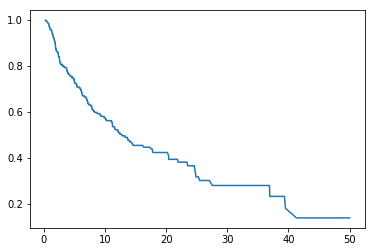

22.5583
False


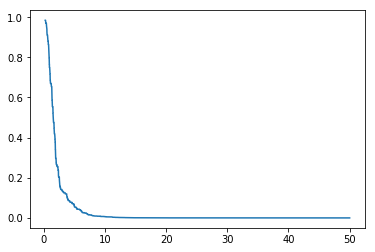

7.6736
False


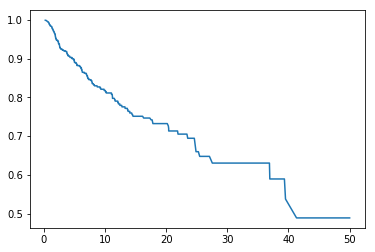

4.2063
False


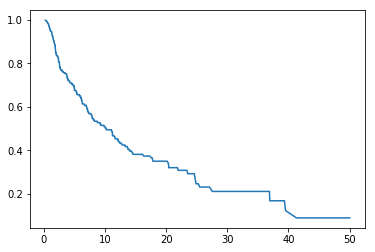

3.7667
False


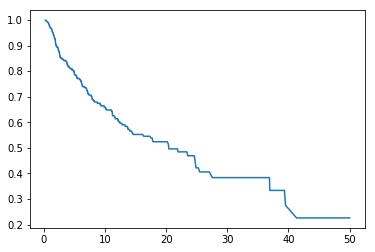

6.9319
True


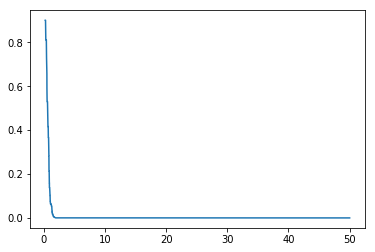

predict death
[0.9972 0.9993 1.0056 1.0153 1.0278 1.0285]

7.9368
False


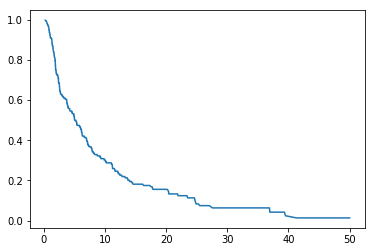

1.7826
False


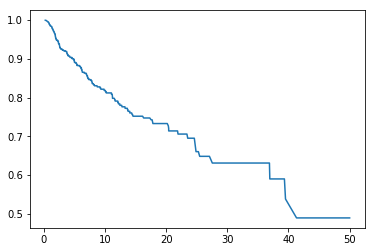

4.6125
False


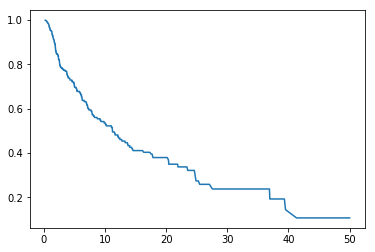

12.5965
True


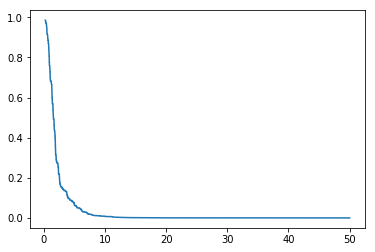

1.9229
False


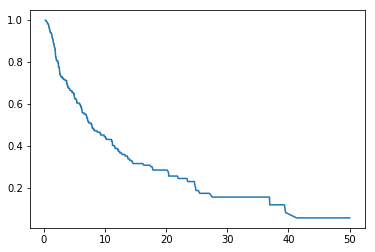

6.9931
False


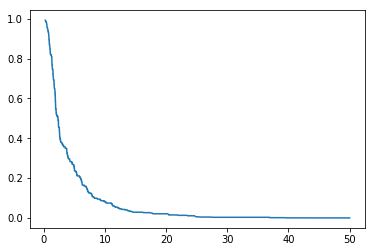

2.9181
False


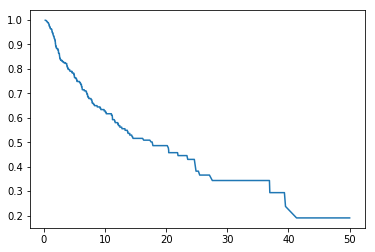

1.9479
False


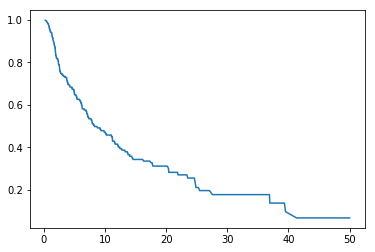

3.8
False


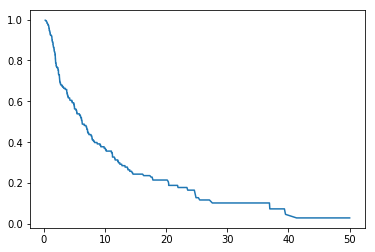

12.0264
False


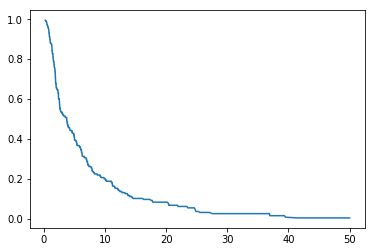

3.5243
False


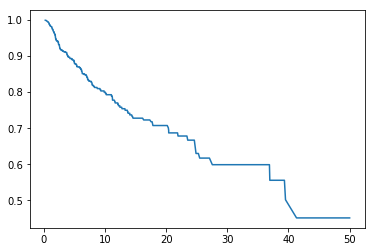

0.5354
False


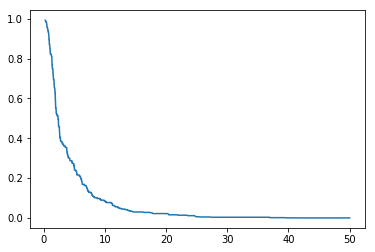

11.9653
False


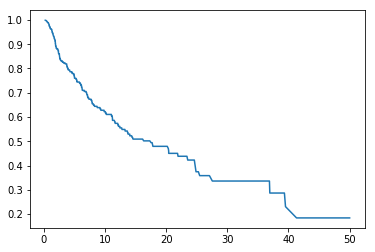

9.3097
False


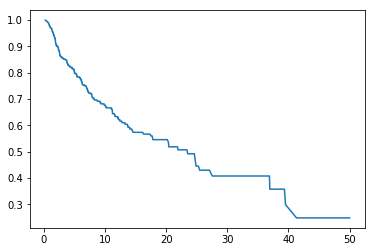

1.7486
False


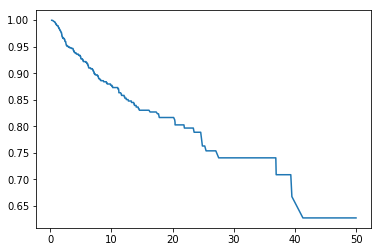

11.8257
False


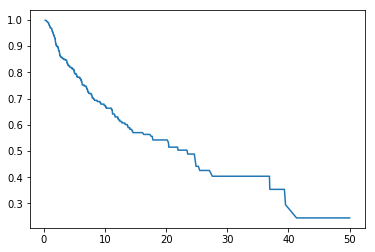

2.1708
False


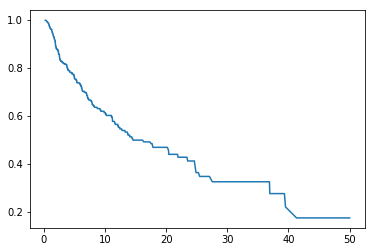

14.8153
False


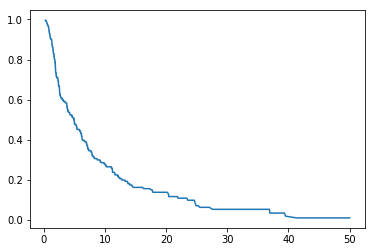

13.1201
False


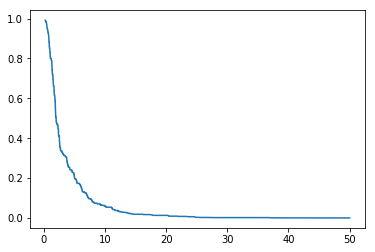

6.7063
False


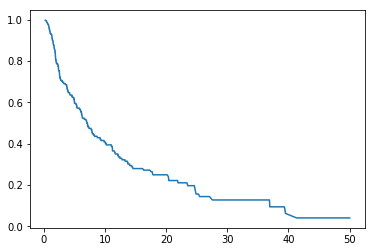

14.9924
False


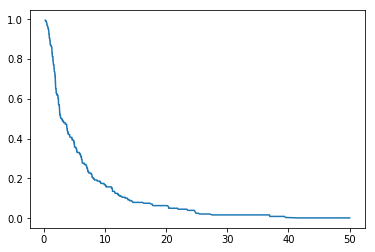

4.6889
False


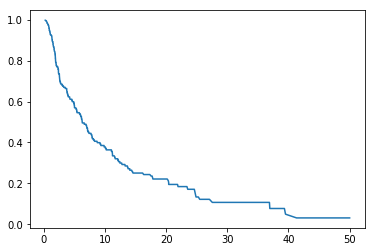

0.7792
True


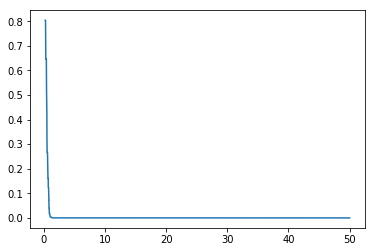

predict death
[0.8    0.8042]

0.9132
False


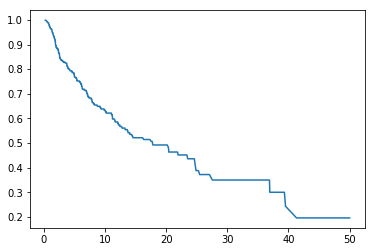

25.9299
False


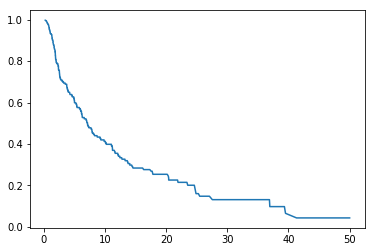

4.3118
False


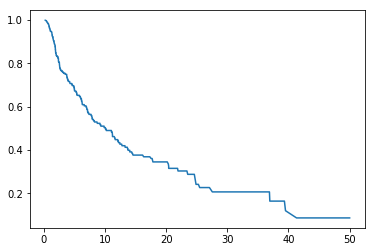

15.9611
False


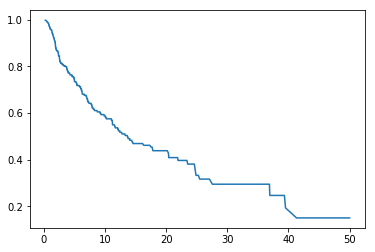

7.7021
False


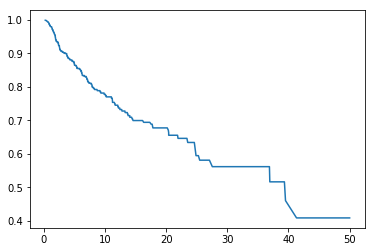

10.0257
False


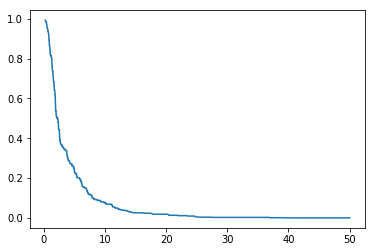

16.0069
True


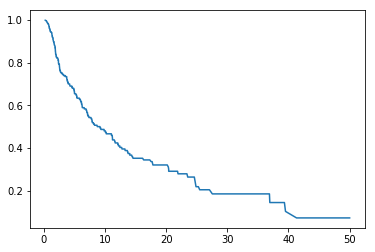

6.8625
False


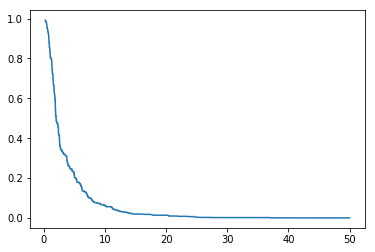

9.5521
False


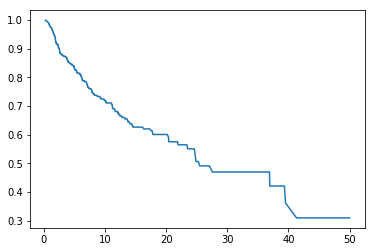

10.8597
False


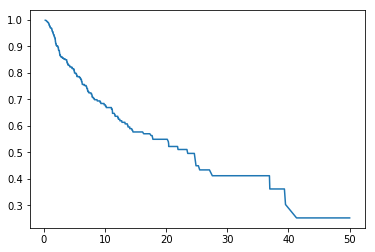

13.8632
False


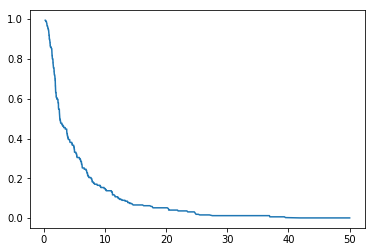

13.5618
True


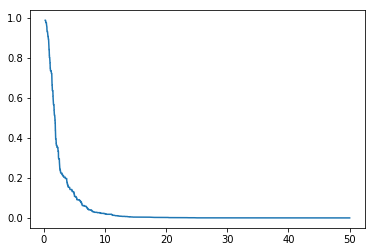

0.6646
False


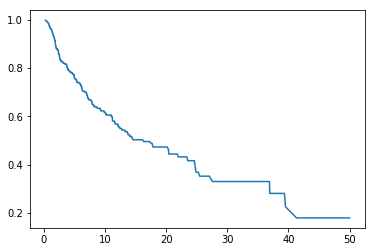

2.8868
False


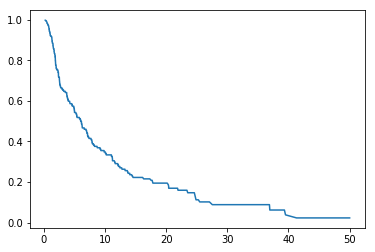

7.6854
False


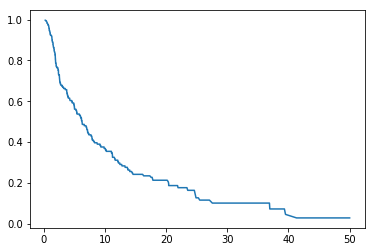

6.2236
False


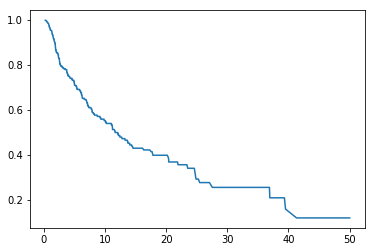

3.5861
False


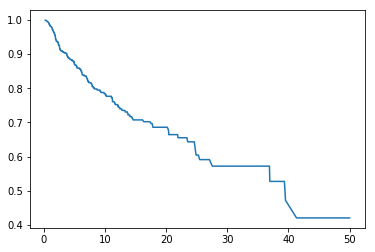

In [341]:
for i in range(100):
    print(y_test['Survival_in_days'][i])
    print(y_test['Status'][i])
    fun = survival[i]
    plt.figure()
    plt.plot(fun.x, fun.y)
    plt.show()
#     print(fun.y)
    
    minvaluey = min(fun.y)
    if (minvaluey < 1e-20):
        print('predict death')
        given_value = 0.1
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_idx = min(fun.y, key=absolute_difference_function)
        print(fun.x[fun.y == closest_idx])
        print()

# fun1 = survival[0]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][0])

# fun1 = survival[1]
# print(fun1)
# print(fun1.x)
# print(fun1.y)
# plt.plot(fun1.x, fun1.y)
# print(y_test['Survival_in_days'][1])

In [239]:
from sksurv.metrics import concordance_index_censored
metric = concordance_index_censored(y_test['Status'], y_test['Survival_in_days'], y_pred)
print(metric)

(0.882280579772156, 16496, 2201, 0, 0)


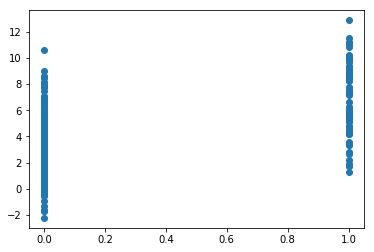

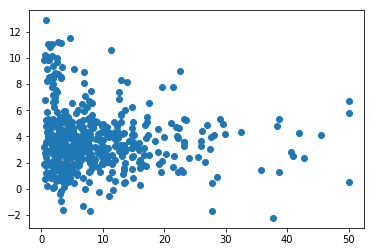

[ 3.37982150e+00  1.89471725e+00  1.10803971e+01  4.05412304e+00
  5.59408762e-01 -1.42129579e-01  1.24967223e+00  4.40305040e-01
  2.12362226e+00  7.75334253e+00  4.17027292e+00  1.11990161e+00
  5.54629199e-01  1.45471117e+00  7.13030503e+00  5.47342053e+00
  1.28492100e+00  2.65497395e+00  2.98035313e+00  3.75970388e+00
  1.73446864e+00  1.16483502e+00  1.78818672e+00  2.31056283e+00
  4.53550142e+00  1.41470075e+00  5.00799316e+00  3.31529940e+00
  2.37444867e+00 -1.57689564e+00  9.11383660e-01  4.26784804e+00
  4.28510497e+00  7.98821511e+00  4.82034276e+00  3.33444553e+00
  4.11177837e+00  6.25442780e+00  5.86270515e+00  2.63683638e+00
  1.90523110e+00  5.91693225e+00  7.00716825e+00  7.75852426e+00
  9.68313104e+00  6.67793306e+00  2.95541271e+00  5.39917720e+00
  3.53578090e+00  2.02242871e+00  2.44105666e+00  2.47247800e+00
  1.45421125e+00  3.78913982e+00 -1.64814096e+00  8.99443371e+00
  2.70123811e+00  5.23282921e+00  1.21490061e+00  8.89960044e+00
  1.96310676e+00  2.93682

In [159]:
plt.figure()
# print(y_test['Status'])
plt.plot(y_test['Status'], y_pred, 'o')
plt.show()

plt.figure()
plt.plot(y_test['Survival_in_days'], y_pred, 'o')
plt.show()

print(y_pred)

In [167]:
# For other survival models that do not rely on the proportional hazards assumption, 
# it is often impossible to estimate survival or cumulative hazard function. Their 
# predictions are risk scores of arbitrary scale. If samples are ordered according 
# to their predicted risk score (in ascending order), one obtains the sequence of 
# events, as predicted by the model. This is the return value of the predict() method
# of all survival models in scikit-survival.


# Ranking the risk scores in ascending order
pred_ranks = np.argsort(y_pred)
print(pred_ranks)

test_ranks = np.argsort(-1*y_test['Survival_in_days'])
print(test_ranks)

[386 166  54  29 504 381 288 211 338   5 277 394 471 417 491 195 436 317
   7 415 494  68 145 267  12   4 324 290 216 138 434 128 429 112 252 287
 137 141 340  30  70 208 393 355 225  11 297  21 174  58 382 301   6  91
 497  16 475 369  87 342 101 281 451  25 117 187 348  52  13 379 263 333
 469 261 322 485 312 482  73 479 502 321 156  99 186 431 207 201 198 199
  20  96 330 422 300 192  22 167 255 313 126 449   1 131 383 303  40  74
 284 435 306 398 157  60 376 309 350  49 367 503 205 140 363 356 428 206
   8 490  89 506 239  72 197 413 401  23 291  79 411 378  28 209 233 134
 296 437 307 478  50 285 334  51 399 162 361 219  92 423 272 457 163 200
 441 353  39 148 232  17 460 194 310 454  56  98 111 444  95 144 360 366
 246 341 113 122 275 282 392 172 249 380 279 153 265 124 130 114 484 391
 222  83 164 129  81 215  61  97 160 123  46 218 269 368  18  76 354 257
  93 468 274 248 191  78 455 213 462 133 467 299 217  77 242 414 446 420
 280  67 336 120 175 149 311 407 107 109  69 335 41

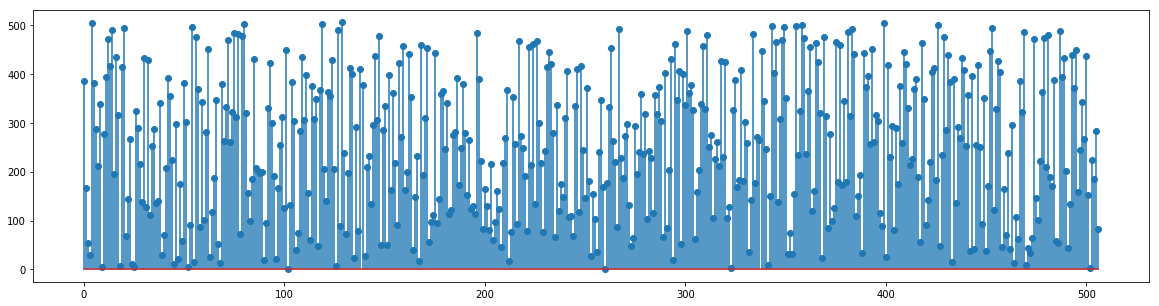

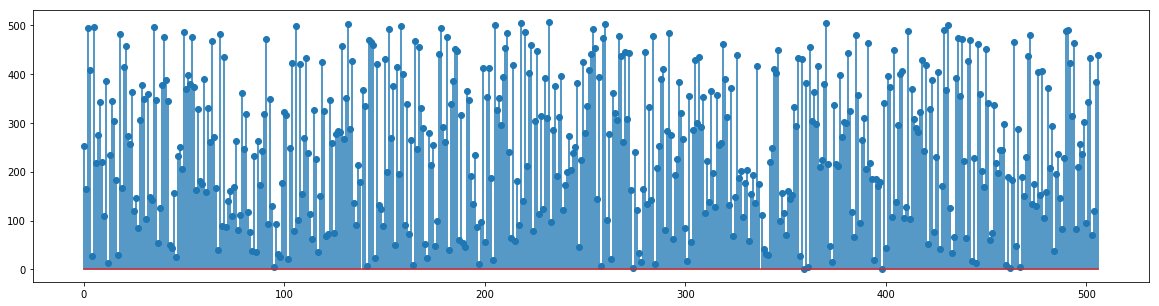

In [172]:
plt.figure(figsize=(20,5))
plt.stem(pred_ranks)
plt.show()

plt.figure(figsize=(20,5))
plt.stem(test_ranks)
plt.show()

Text(0, 0.5, 'Predicted Risk Score')

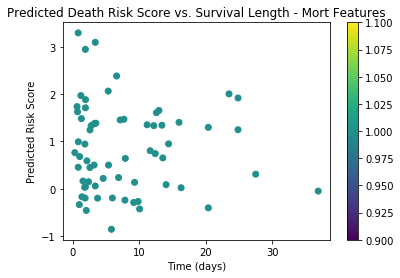

In [378]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
classes = ListedColormap(['Death','Survival'])
plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
plt.title('Predicted Death Risk Score vs. Survival Length - Mort Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')

Text(0, 0.5, 'Predicted Risk Score')

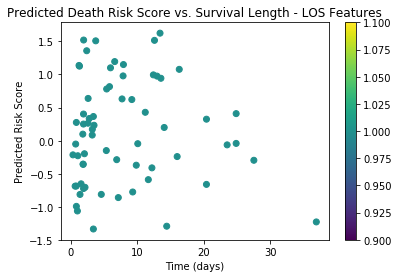

In [381]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
classes = ListedColormap(['Death','Survival'])
plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
plt.title('Predicted Death Risk Score vs. Survival Length - LOS Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')


Text(0, 0.5, 'Predicted Risk Score')

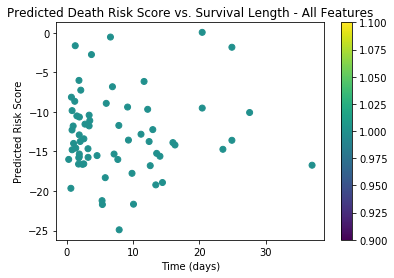

In [375]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()

y_pred_scaled = scaler1.fit_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler2.fit_transform(y_test['Survival_in_days'].reshape(-1, 1))

plt.figure()
# plt.scatter(y_test['Survival_in_days'], y_pred, c=[not i for i in y_test['Status']])
plt.scatter(y_test['Survival_in_days'], y_pred, c=y_test['Status'])
classes = ListedColormap(['Death','Survival'])
plt.colorbar() # 1 (Death) is yellow, 0 (Survival) is purple
plt.title('Predicted Death Risk Score vs. Survival Length - All Features')
plt.xlabel('Time (days)')
plt.ylabel('Predicted Risk Score')